# 4.2.5 Boston Marathon

Challenge Info: There is a lot of information on runners and their performance for the Boston Marathon. Pick a year and do some clustering.
Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish.

In [254]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
%matplotlib inline

URL-->https://github.com/llimllib/bostonmarathon/blob/master/results/2013/results.csv

In [321]:
data = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')
data.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [272]:
data.isnull().sum()

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

In [322]:
# Deriving the column flag to determine if its male or not
data['Gender_Flag']=np.where(data['gender']=='M',1,0)

# Preprocessing and Data Cleaning

In [323]:
#
splits = ['5k', '10k',  '20k', 'half','25k', '30k', '35k', '40k']

for dist in splits:
       #df[dist] = df[dist].fillna(np.mean(df[dist]))
    data[dist] = pd.to_numeric(data[dist], errors='coerce')
    data[dist] = data[dist].map(lambda x: data[dist].mean() if x is '-' else float(x))


In [324]:
# Taking the relevant number of columns for the clustering 
df= data[['division', 'age', 'official', 'genderdiv', 'half','overall', 'pace','30k','5k','20k','35k','40k','25k','10k','Gender_Flag']].dropna(0)
#df = pd.DataFrame(data=df)


In [314]:
#Check the number of nulls in the records
df.count()

division       16054
age            16054
official       16054
genderdiv      16054
half           16054
overall        16054
pace           16054
30k            16054
5k             16054
20k            16054
35k            16054
40k            16054
25k            16054
10k            16054
Gender_Flag    16054
dtype: int64

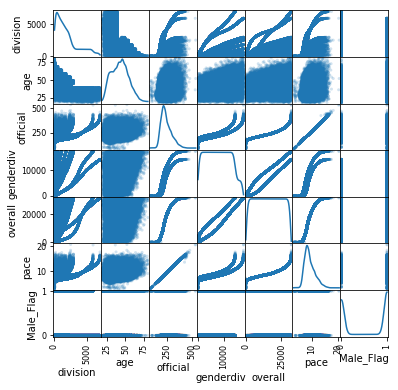

In [52]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde');

Text(0.5,1,'Age Histogram')

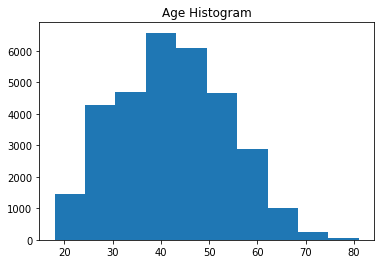

In [56]:
plt.hist(df['age'])
plt.title("Age Histogram")

# X input variables

In [332]:
#Since its a unsupervised learning, we will chose only X input variables
X=df.iloc[:,0:15]


Text(0.5, 1.0, 'Variable Correlation')

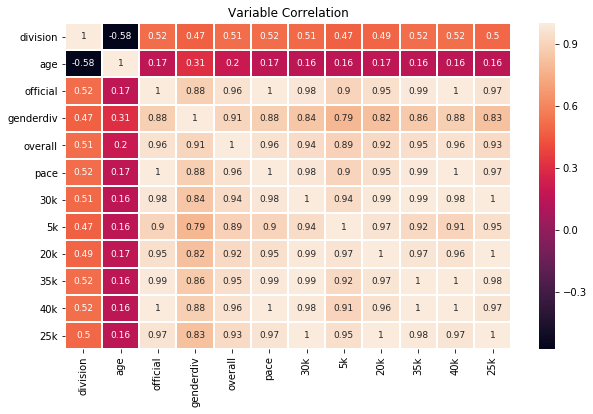

In [159]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(),linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

There look to be some correlation between the features as seen above in the correlation matrix

In [337]:
X_norm = normalize(X)
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)
# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

4013 4013
4014 4014
4013 4013
4014 4014


In [338]:
X2 = X2[:4013]
X4 = X4[:4013]
X_pca2 = X_pca2[:4013]
X_pca4 = X_pca4[:4013]
X_pca2 = X_pca2[:4013]       
print(len(X4), len(X_pca4))
print(len(X2), len(X_pca2))

4013 4013
4013 4013


# K-MEANS CLUSTER

In [339]:
# Initialize data frames
ypred_df = pd.DataFrame()
scores_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    
    # Creating a list of possible number of clusters to test in kmeans.
    for n_cluster in range(2, 6): 
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred_df['cluster ' + str(n_cluster) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        scores_df = scores_df.append({'cluster_pred':'cluster ' + str(n_cluster) + '_sample ' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)

In [340]:
# Sorting sihoilette scores
scores_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
7,cluster 5_sample 1,0.634536
2,cluster 4_sample 0,0.633268
11,cluster 5_sample 2,0.632638
6,cluster 4_sample 1,0.631976
15,cluster 5_sample 3,0.631302
10,cluster 4_sample 2,0.630755
14,cluster 4_sample 3,0.630060
9,cluster 3_sample 2,0.601554
5,cluster 3_sample 1,0.599485
1,cluster 3_sample 0,0.595198


Silhouette score is not that great as seen above which means model accuracy is not good expected.This might be due to few reason such as preprocessing not done effeciently so that model can accept the data or data itself is not sufficient to get a good accuracy using k means.Here cluster5 seems to have score than other clusters

# Mean-Shift Cluster

In [363]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances

ypred_ms_df = pd.DataFrame()
score_ms_df = pd.DataFrame(columns=['cluster_pred','sil_score', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms_df['cluster ' + str(cntrs) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms_df = score_ms_df.append({'cluster_pred':'cluster ' + str(cntrs) + '_sample ' + str(counter), 
                              'sil_score':sscore, 'quantile':n}, ignore_index=True)


In [364]:
score_ms_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score,quantile
4,cluster 5_sample 1,0.634905,0.2
1,cluster 4_sample 0,0.633391,0.2
2,cluster 6_sample 0,0.632797,0.3
10,cluster 5_sample 3,0.630324,0.2
5,cluster 4_sample 1,0.629312,0.3
8,cluster 4_sample 2,0.628176,0.3
11,cluster 4_sample 3,0.624060,0.3
7,cluster 3_sample 2,0.600894,0.2
6,cluster 7_sample 2,0.556527,0.1
3,cluster 8_sample 1,0.555469,0.1


Silhouette score is not that great as seen above which means model accuracy is not good expected.This might be due to few reason such as preprocessing not done effeciently so that model can accept the data or data itself is not sufficient to get a good accuracy using mean-shift .Here cluster5 seems to have score than other clusters

# Spectral Clustering

In [345]:
from sklearn.cluster import SpectralClustering
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [346]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
7,clust5_sample1,0.631322
3,clust5_sample0,0.630738
11,clust5_sample2,0.629222
15,clust5_sample3,0.627261
10,clust4_sample2,0.624988
6,clust4_sample1,0.621722
2,clust4_sample0,0.620063
14,clust4_sample3,0.615166
9,clust3_sample2,0.547256
5,clust3_sample1,0.545136


Silhouette score is not that great as seen above which means model accuracy is not good expected.This might be due to few reason such as preprocessing not done effeciently so that model can accept the data or data itself is not sufficient to get a good accuracy using spectral clustering.Here cluster5 seems to have score than other clusters

# Affinity Clustering

In [347]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Initialize data frame
score_ap_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_ap_df = score_ap_df.append({'cluster_pred':'cluster ' + str(n_clusters_) + '_sample ' + str(counter), 
                              'sil_score':sscore_af}, ignore_index=True)

In [348]:
score_ap_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
1,cluster 1197_sample 1,0.212540
2,cluster 1791_sample 2,0.157716
0,cluster 2395_sample 0,0.117204
3,cluster 2334_sample 3,0.112136


Silhouette score is very poor.Affinity clustering is not good for getting good accuracies and it usually has lot of clusters.So,it is not usually used for getting accuracy

# Conclusion:

Overall, the 5-cluster solution  has the highest Silhouette scores. The K mean model generated the highest Silhouette score . This drives us to the conclusion that the are 5 main group of runners in this marathon. The following information corresponds to results obtained using the K mean model and 5 clusters:

In [451]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_norm)


In [452]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [454]:
# Combining the cluster to X values
df_comb = X.join(df_clust, how='inner')
df_comb.head()

,division,age,official,genderdiv,half,overall,pace,30k,5k,20k,35k,40k,25k,10k,Gender_Flag,Cluster
0,9,28,90.90,9,40.93,9,3.47,62.07,8.90,38.80,74.73,85.55,49.87,18.18,1,3
1,5,30,132.50,5,64.90,5,5.07,92.97,15.90,61.52,108.78,124.77,77.27,30.90,1,3
2,1,23,130.37,1,64.92,1,4.98,92.72,15.93,61.53,108.68,123.78,77.23,30.90,1,3
3,5,32,88.43,5,42.00,5,3.38,61.35,8.98,39.88,73.00,83.43,50.50,18.73,1,3
4,3,39,87.22,3,40.57,3,3.33,59.92,8.92,38.55,71.68,81.88,48.75,18.18,1,3


Now, lets do a deep analysis with the runners based on male and female with their age groups and their clusters

In [457]:
# Create age groups
def age_group(age):
   
    if age <=20:
        return 'Under 20'
    elif (age > 20 and age <= 30):
        return 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        return 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        return 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        return 'Between 50 and 60'
    else:
        return 'Over 60'
    
   

In [458]:
df_comb['Age_Group']=df_comb['age'].apply(lambda x:age_group(x))

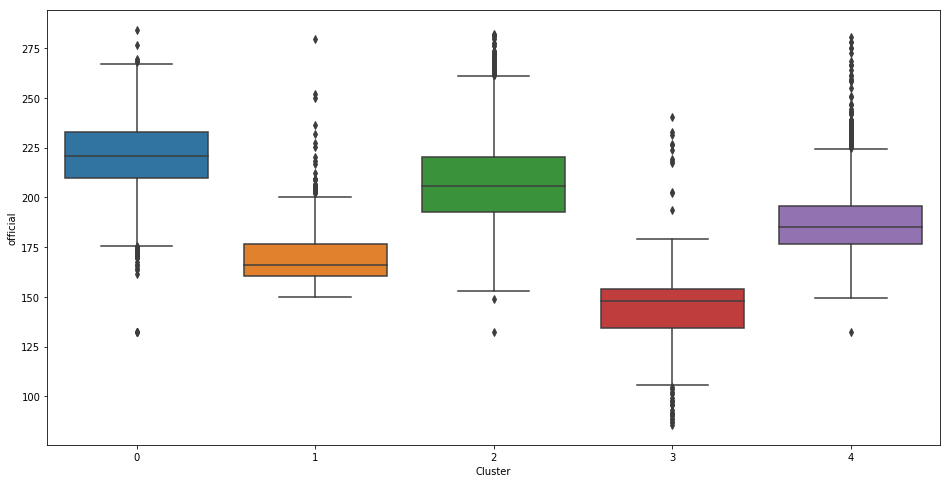

In [455]:

# Official time between the groups
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster',y='official',data=df_comb)

The above boxplot shows the official time taken by the runners and their clusters where runners fall.It looks like minimum taken taken by runners fall in Cluster3 and maximum time in cluster, so that  means cluster 3 has the fastest runners in all the clusters

Now,lets analyse more for time taken by runners per their age group

C:\Users\ankush\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ankush\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


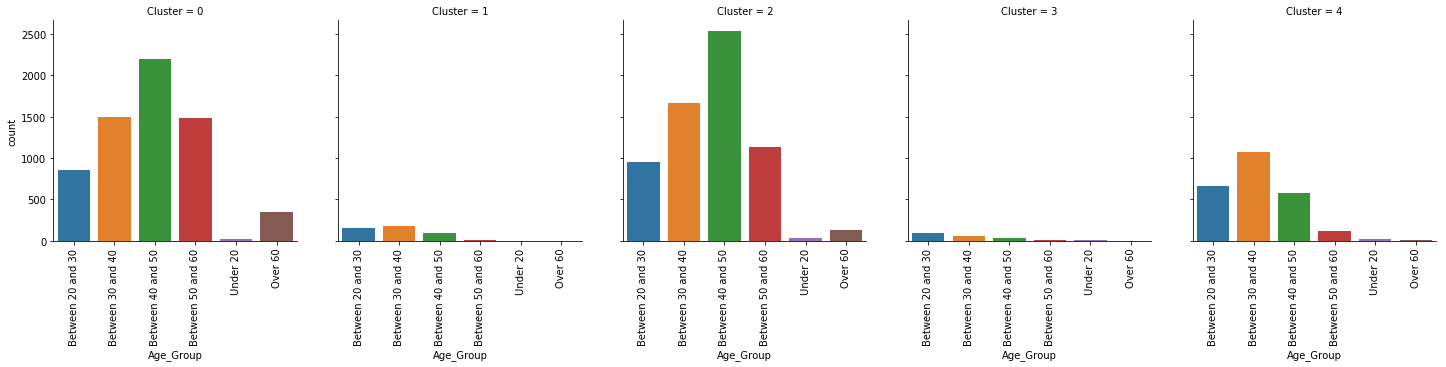

In [459]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='Age_Group', col='Cluster', kind="count", data=df_comb, size=4)
g.set_xticklabels(rotation=90)

The above shows that cluster 2 has maximum number of runners between age 40 and 50,Cluster3 between age 20 and 30

C:\Users\ankush\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ankush\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


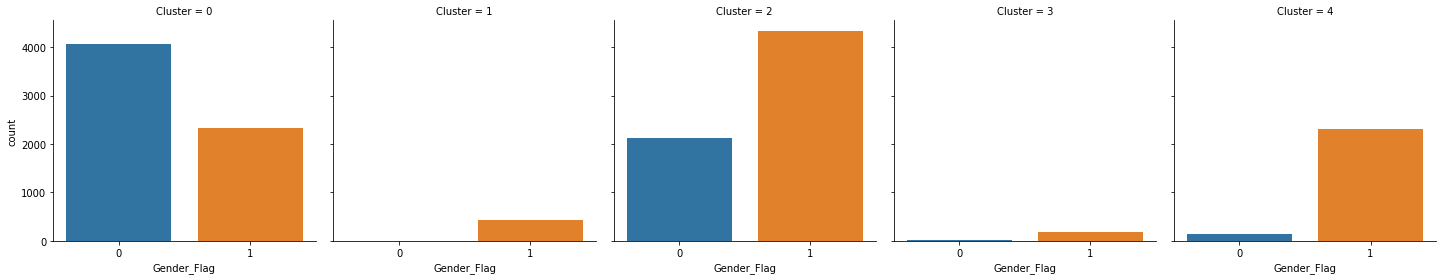

In [460]:
sns.factorplot(x='Gender_Flag', col='Cluster', kind="count", data=df_comb, size=4)

From above, it shows that Flag with 1 i.e Males are significantly more in Cluster0 and cluster2 and Females are more in Cluster1

Now, lets take a look at  the number of number of males and females in each cluster

In [481]:
df_gender = df_comb.groupby(['Cluster','Gender_Flag'])['Gender_Flag'].count().rename('head_count').reset_index()

In [483]:
df_gender['percentage'] = df_gender.head_count / df_gender.head_count.sum()

In [484]:
df_gender

,Cluster,Gender_Flag,head_count,percentage
0,0,0,4059,0.254563
1,0,1,2340,0.146754
2,1,0,3,0.000188
3,1,1,424,0.026591
4,2,0,2127,0.133396
5,2,1,4337,0.271997
6,3,0,13,0.000815
7,3,1,187,0.011728
8,4,0,147,0.009219
9,4,1,2308,0.144748


The above shows that cluster0 has maximum number of female runners and cluster1 has maximum number of male runners